In [1]:
%load_ext autoreload
%autoreload 2

NOTE: This notebook can be run from a later step, but some cells are crucial to run before others. If you want to run the notebook from a later step, make sure to run the cells specified in the previous steps first. This is just below each heading in the parentheses!


# Step 1: Gathering the data
(You can skip to the next step if you already have the parquets in floor)

Before we can start to play with the data, we need to gather it. The data is stored in a MongoDB database. The `loader.py` script will load the data from the database, apply the transformers and save the result to a file. The transformers are defined in the `transformers` directory.

The loader can be run from the command line, or we can import it as a module and use it in a notebook. It can either use cached data, which is stored in the `cache` directory once it has been loaded from the database, or it can load the data from the database directly. To load from the database, pass the `--cache-mode` or `-c` option to the CLI or use the `cache_mode` argument when running the loader's `run()` function. Possible values are `auto`, `force-local`, and `force-refresh`.

In [2]:
from loader import run
need_to_gather_data = False # set to True to rebuild the data parquet files
use_fresh_data = False # set to True to use the latest data from DB
if need_to_gather_data:
    mode = 'force-refresh' if use_fresh_data else 'auto'
    run(cache_mode=mode)

# Step 2: Training
(You can run only the next two cells and skip to the next step if you already have the model pickled)

Once the loader has loaded the data and applied the transformations, we can load the resulting parquets and prepare for model training. We then split the data into training and test sets and train a model.

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq

phishing = pq.read_table('floor/phishing.parquet')
benign = pq.read_table('floor/benign.parquet')

from transformers.drop_nontrain import drop_nontrain
phishing = drop_nontrain(phishing)
benign = drop_nontrain(benign)

# realign schemas (parquet files save in nonsense orders)
benign = benign.cast(phishing.schema)

# concatentate tables
data = pa.concat_tables([phishing, benign])
df = data.to_pandas()

from transformers.cast_timestamp import cast_timestamp
df = cast_timestamp(df)

df

,label,tls_CA_certs_in_chain_ratio,tls_broken_chain,tls_chain_len,tls_cipher_id,tls_client_auth_crt_count,tls_common_name_count,tls_critical_extensions,tls_expired_chain,tls_has_tls,tls_iso_policy_crt_count,tls_iso_policy_oid,tls_isoitu_policy_oid,tls_joint_isoitu_policy_crt_count,tls_leaf_cert_validity_len,tls_leaf_cert_validity_remaining,tls_percentage_crt_with_policies,tls_root_cert_validity_len,tls_root_cert_validity_remaining,tls_server_auth_crt_count,tls_subject_count,tls_total_extension_count,tls_unique_SLD_count,tls_unknown_policy_crt_count,tls_version_id,tls_with_policies_crt_count,tls_x509_anypolicy_crt_count,lex_name_len,lex_digit_count,lex_has_digit,lex_phishing_keyword_count,lex_vowel_count,lex_underscore_hyphen_count,lex_consecutive_chars,lex_tld_len,lex_sld_len,lex_sub_count,lex_stld_unique_char_count,lex_begins_with_digit,lex_www_flag,lex_sub_max_consonant_len,lex_sub_norm_entropy,lex_sub_digit_count,lex_sub_digit_ratio,lex_sub_consonant_ratio,lex_sub_non_alphanum_ratio,lex_sub_hex_ratio,ip_entropy,ip_mean_average_rtt,geo_countries_count,geo_continent_hash,geo_countries_hash,rdap_domain_registration_period,rdap_has_dnssec,dns_A_count,dns_AAAA_count,dns_CNAME_count,dns_MX_count,dns_NS_count,dns_SOA_count,dns_TXT_count,dns_soa_primary_ns_len,dns_soa_primary_ns_subdomain_count,dns_soa_primary_ns_digit_count,dns_soa_primary_ns_entropy,dns_soa_admin_email_len,dns_soa_admin_email_subdomain_count,dns_soa_admin_email_digit_count,dns_soa_admin_email_entropy,dns_soa_serial,dns_soa_refresh,dns_soa_retry,dns_soa_expire,dns_soa_neg_resp_caching_ttl,dns_mx_mean_len,dns_mx_mean_entropy,dns_domain_name_in_mx,dns_txt_google_verified,dns_txt_spf_exists,dns_txt_mean_entropy
0,misp:phishing,0.500000,0.0,4.0,0.0,2.0,3.0,7.0,0.0,True,0,0,223140121,2,345.0,329.0,1.00,9066.0,4129.0,2.0,8.0,31.0,2.0,0,2.0,4,2,34,0,0,0,11,2,1,2,6,1,8,0,0,3,0.132997,0.0,0.000000,0.600000,0.066667,0.333333,2.5,98.4360,1,4,9000,NaN,False,4,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
1,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,35,10,1,0,7,3,2,3,7,2,8,0,0,3,0.137184,10.0,0.285714,0.344828,0.103448,0.551724,1.0,0.0000,1,3,184,NaN,False,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,17,0,0,0,9,0,3,3,13,0,8,0,0,2,0.221011,0.0,0.000000,0.384615,0.000000,0.461538,0.0,-1.0000,0,0,0,NaN,False,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
3,misp:phishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,0,22,0,0,0,5,0,2,3,8,1,8,0,0,8,0.210145,0.0,0.000000,0.823529,0.000000,0.117647,1.0,0.0000,1,3,186,NaN,False,1,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,0.180235,0,0,0,NaN
4,misp:phishing,0.333333,0.0,3.0,1.0,2.0,3.0,5.0,0.0,True,2,1919110699,0,0,396.0,357.0,1.00,3583.0,2124.0,2.0,2.0,24.0,1.0,0,3.0,3,1,29,4,1,1,11,1,2,2,4,1,6,0,0,2,0.163354,4.0,0.137931,0.400000,0.040000,0.440000,1.0,0.0000,1,0,144,NaN,False,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295348,benign:unknown,0.500000,0.0,4.0,2.0,2.0,4.0,7.0,0.0,True,1,1265652894,0,0,366.0,327.0,0.75,9132.0,2124.0,2.0,2.0,27.0,1.0,0,3.0,3,2,23,0,0,0,7,0,3,3,15,0,13,0,1,4,0.189966,0.0,0.000000,0.666667,0.000000,0.333333,1.0,3.7640,1,1,600,NaN,False,1,0,1,0,2,1,0,23.0,4.0,0.0,0.16265,19.0,3.0,0.0,0.188243,2.277729e+09,10000.0,2400.0,604800.0,3600.0,NaN,NaN,0,0,0,NaN
295349,benign:unknown,0.333333,0.0,3.0,2.0,2.0,3.0

In [4]:
# create train and test sets
from sklearn.model_selection import train_test_split
class_map = {"benign:unknown": 0, "misp:phishing": 1}

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

X_train, X_test, y_train, y_test = train_test_split(
  features,
  labels,
  test_size=0.3,
  random_state=42,
  shuffle=True,
  stratify=labels
)

In [5]:
from xgboost import XGBClassifier
# uncomment the two disabled lines to use GPU
params = {
    "max_depth": 9,
    "eta": 0.15,
    "objective": "binary:logistic",
    #"tree_method": "gpu_hist",
    "min_child_weight": 2.0,
    "subsample": 0.6,
    #"sampling_method": "gradient_based",
    "alpha": 0,
    "gamma": 0.1,
    "lambda": 1.0,
    "max_delta_step": 0,
    "grow_policy": "lossguide",
    "max_bin": 512,
}
trees = 240

model = XGBClassifier(
  **params,
  n_estimators=trees,
  eval_metric=["error", "logloss", "auc"]
)

# set to True to cross validate
do_cross_val = False
if do_cross_val:
  from sklearn.model_selection import StratifiedKFold
  from sklearn.model_selection import cross_val_score
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
  results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  print("F1: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# at last, train the model
eval_set = [(X_train, y_train), (X_test, y_test)]
_ = model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

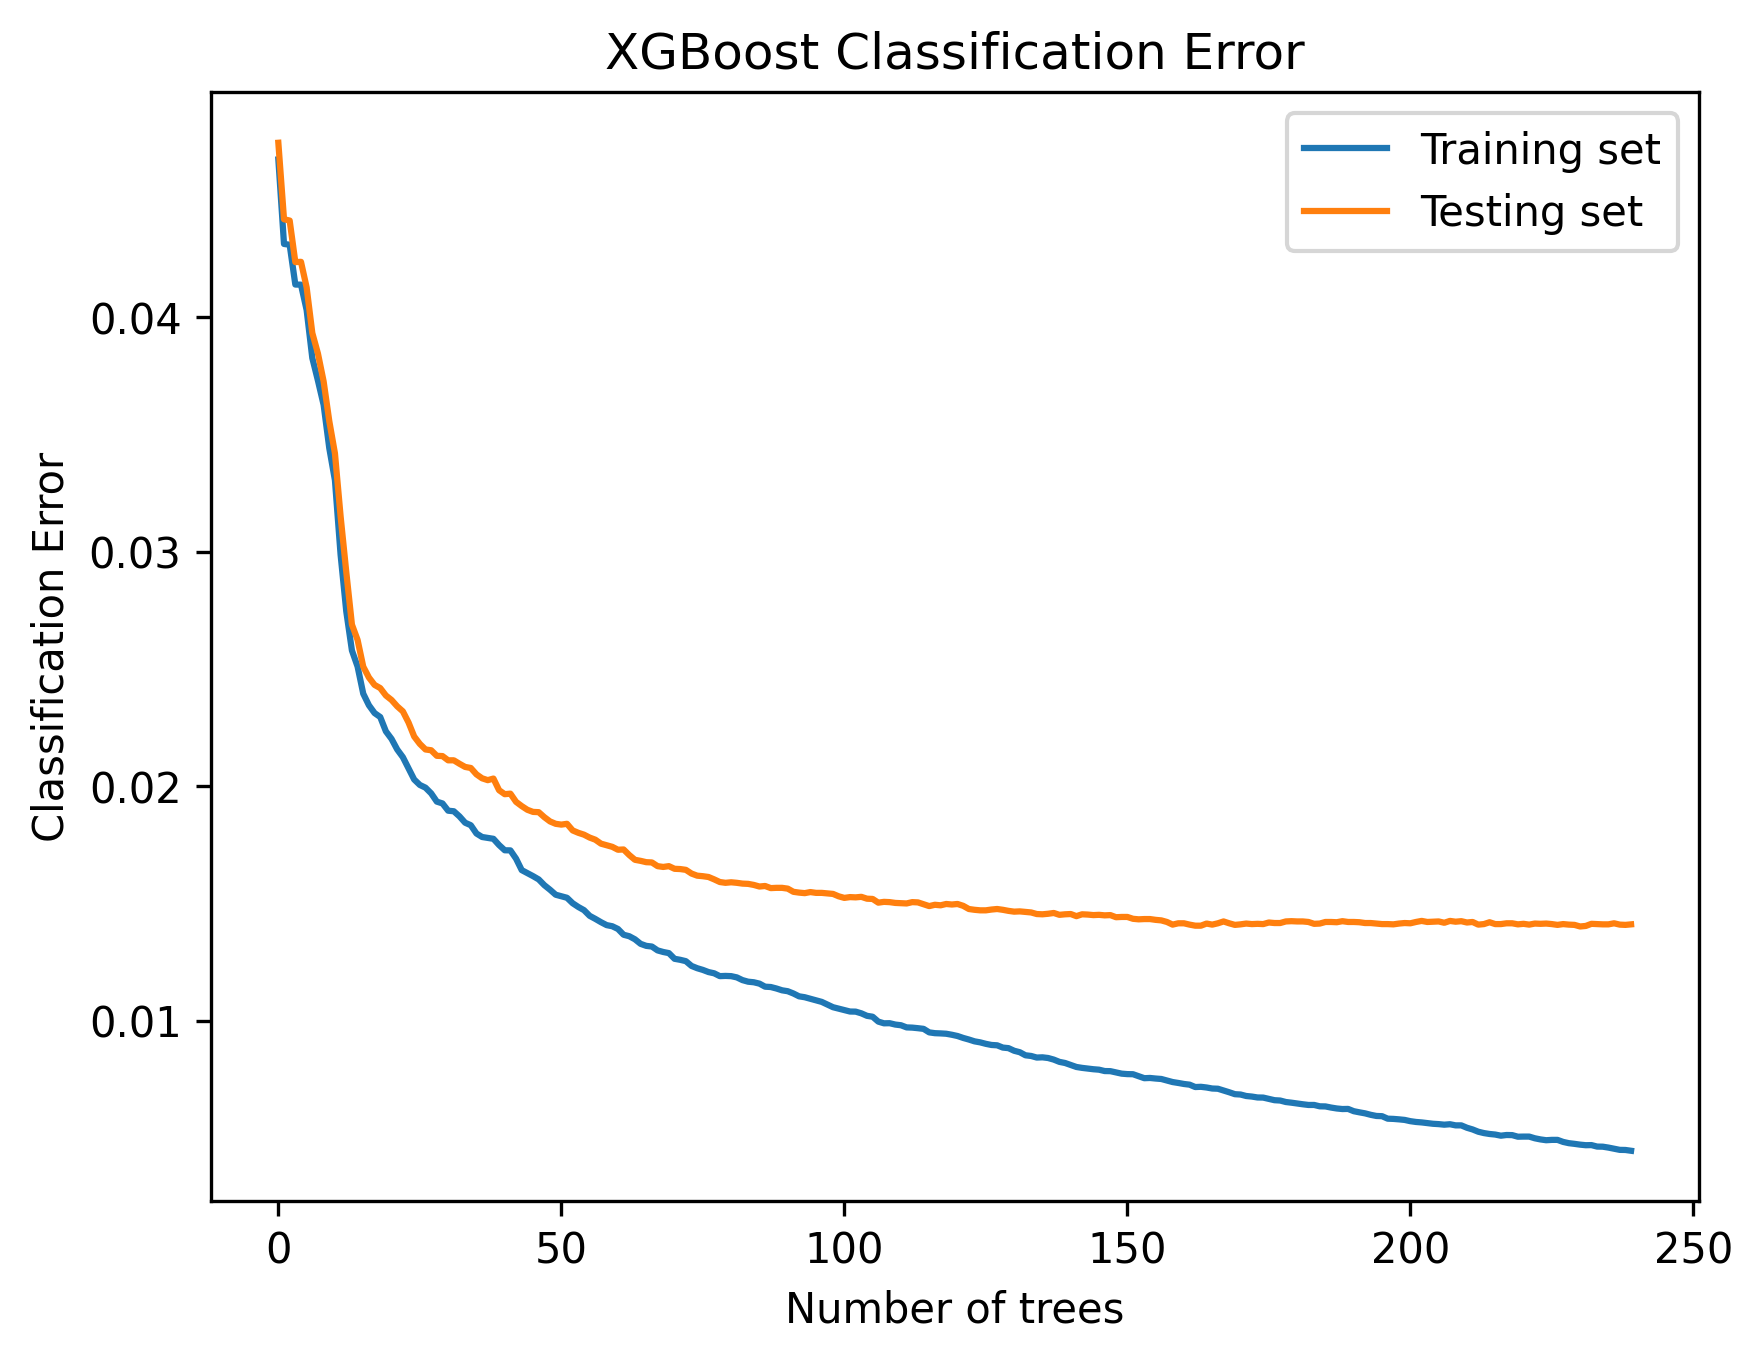

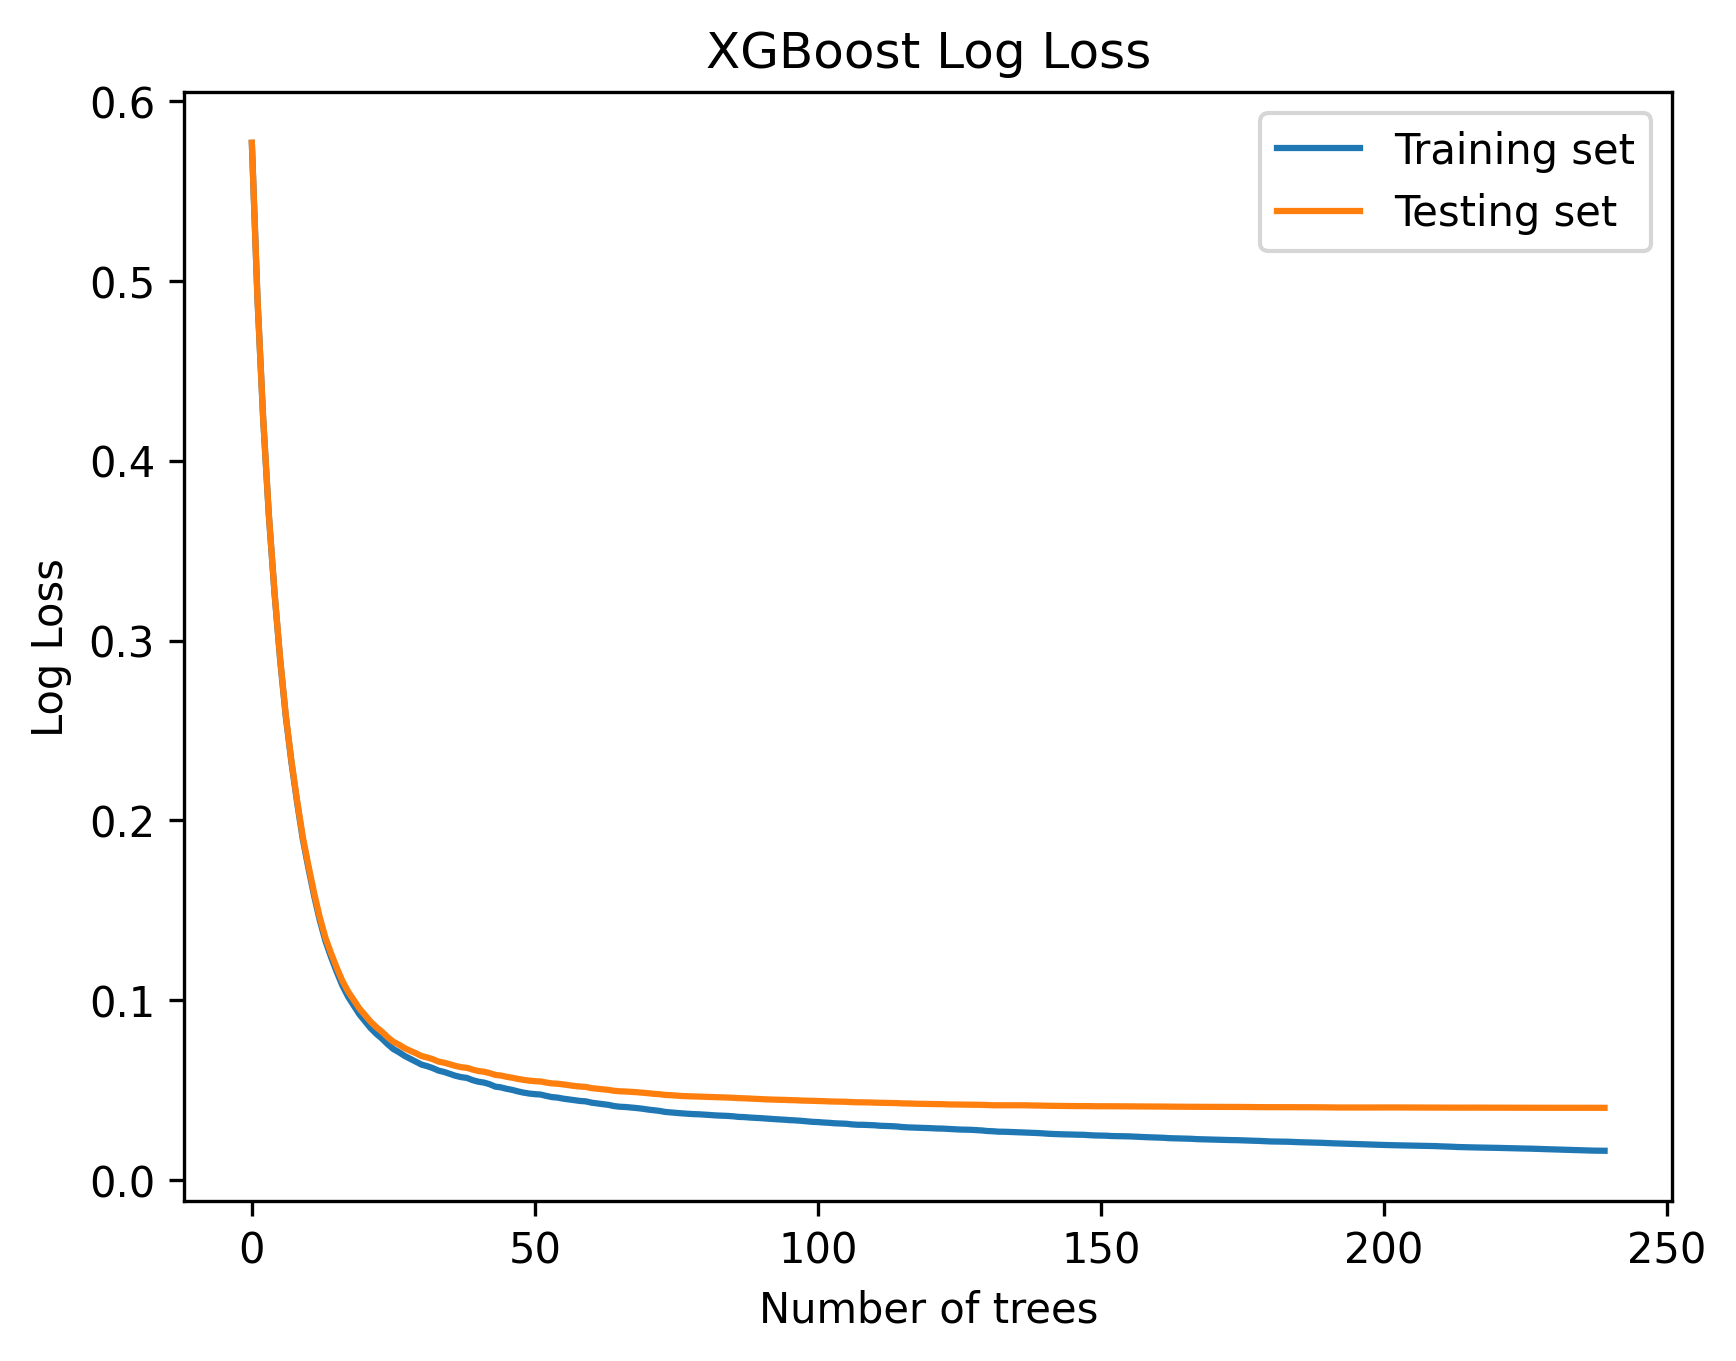

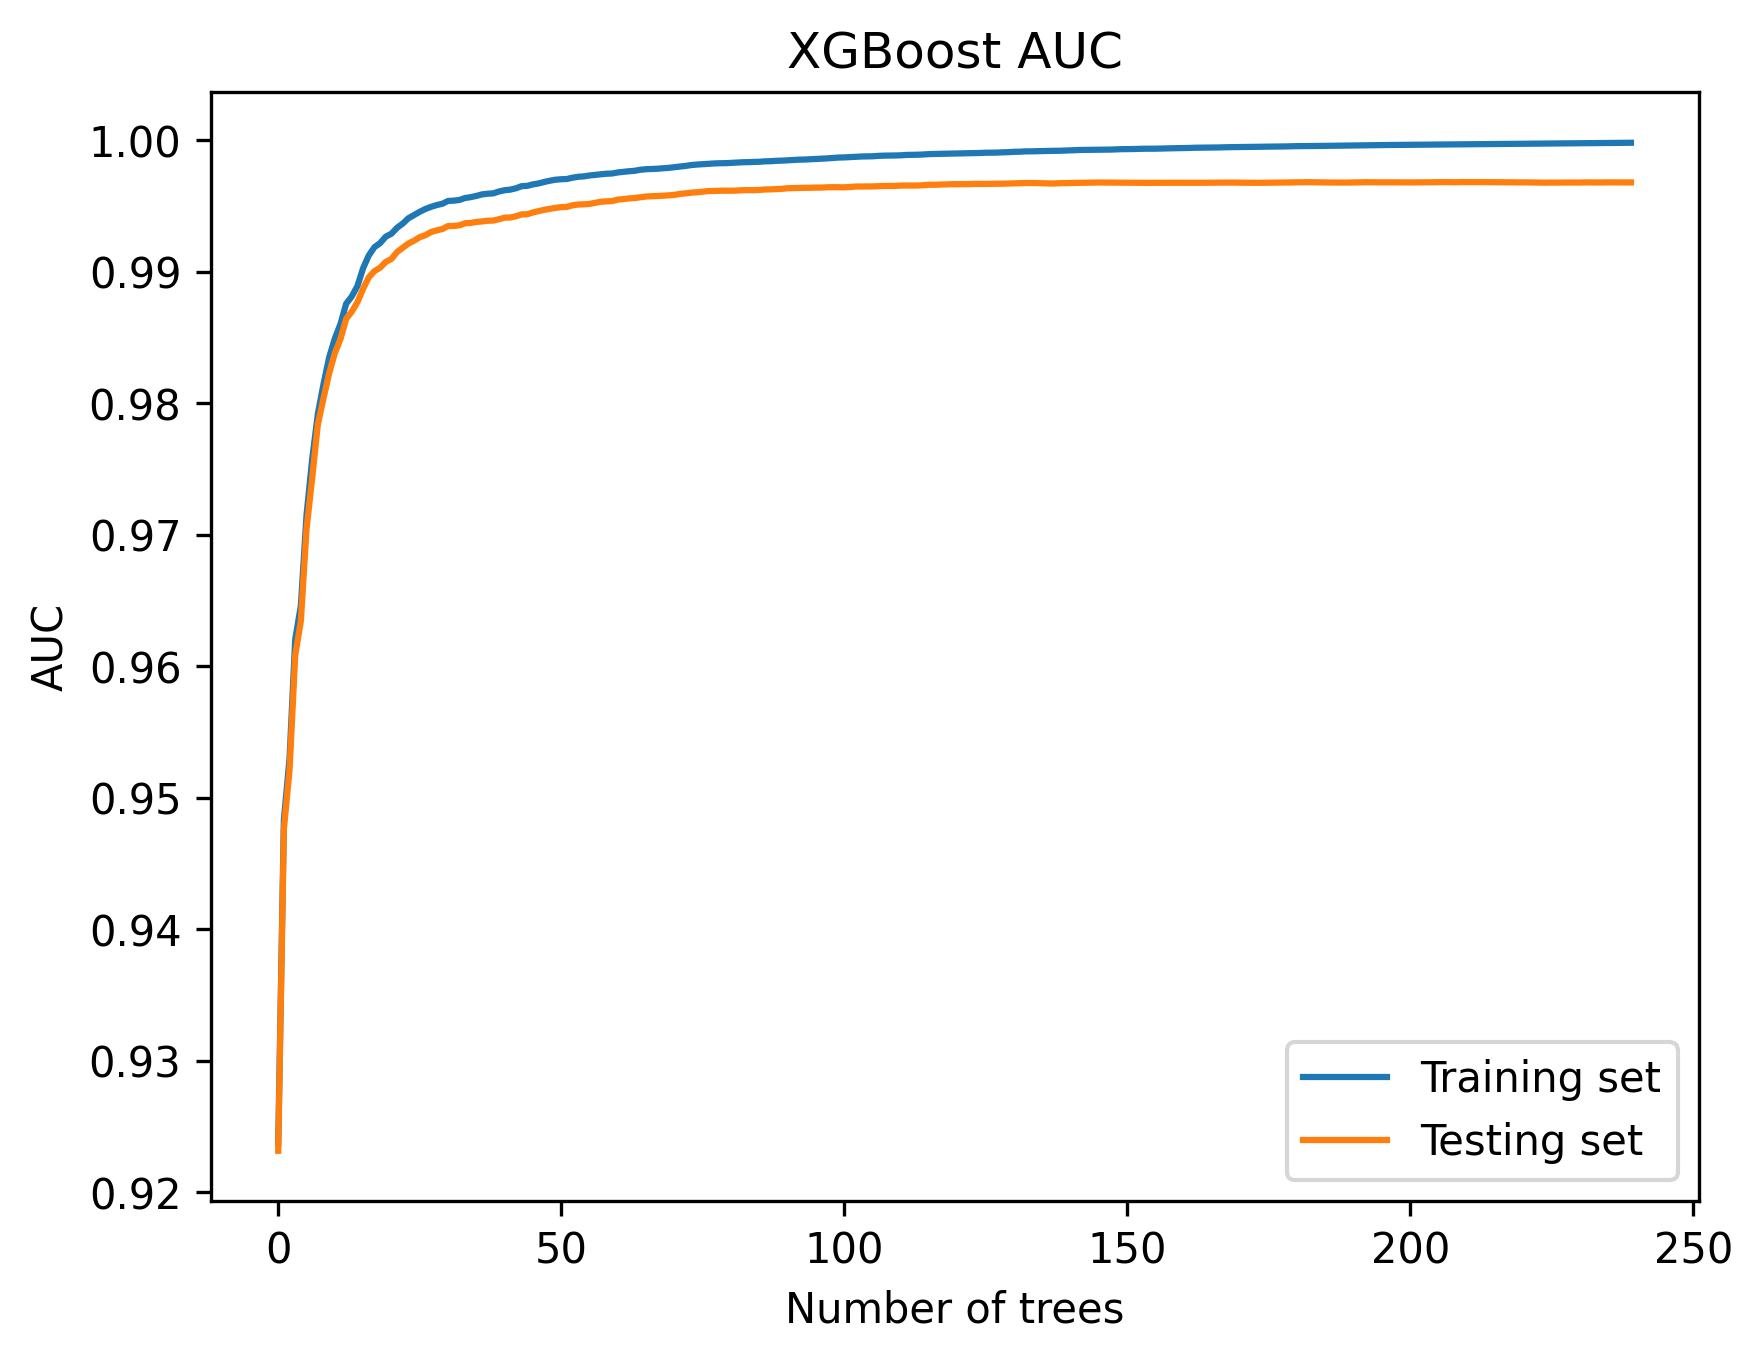

In [6]:
# plot evaluation
results = model.evals_result()
trees = len(results['validation_0']['error'])
x_axis = range(0, trees)

def plot_metric(metric):
    import matplotlib.pyplot as plt
    plt.rcParams["figure.dpi"] = 300
    #
    plt.plot(x_axis, results['validation_0'][metric], label='Training set')
    plt.plot(x_axis, results['validation_1'][metric], label='Testing set')
    plt.legend()
    mnames = {'error': 'Classification Error', 'logloss': 'Log Loss', 'auc': 'AUC'}
    mname = mnames[metric]
    plt.ylabel(mname)
    plt.xlabel('Number of trees')
    plt.title('XGBoost ' + mname)
    plt.show()

plot_metric('error')
plot_metric('logloss')
plot_metric('auc')

If you want to find the optimal set of hyperparameters (that is, the parameters for the model itself), you can use grid search. This will try all combinations of the parameters you specify and return the best one. This is a computationally expensive process, so it is recommended to run it on a machine with a GPU. The following cell shows a grid search, but is disabled by default. If you want to run it, set `run_grid_search` to `True`.

In [7]:
# Hyperparameter tuning
run_grid_search = False
if run_grid_search:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    class_map = {"benign:unknown": 0, "misp:phishing": 1}
    labels = df['label'].apply(lambda x: class_map[x])
    features = df.drop('label', axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42, shuffle=True, stratify=labels)

    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedKFold
    from xgboost import XGBClassifier

    params = {
        "eta": 0.15,
        "objective": "binary:logistic",
        "tree_method": "gpu_hist",
        #"predictor": "gpu_predictor"
    }
    trees = 240

    clf = XGBClassifier(**params)

    # this is your grid of parameters to search through, every combination will be tried
    grid = {
        "max_depth": [9],
        "min_child_weight": [2],
        "sampling_method": ["gradient_based"],
        "subsample": [0.6],
        "gamma": [0.1],
        "grow_policy": ["lossguide"],
        "max_bin": [512],
        "n_estimators": [240, 350, 500],
        "lambda": [1.0],
        "alpha": [0.0]
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=grid,
        #n_jobs=-1,
        cv=cv,
        scoring='neg_log_loss',#'f1',
        verbose=3,
        return_train_score=True
    )

    grid_search.fit(X_train, y_train)

    clf = grid_search.best_estimator_

    scores = pd.DataFrame(grid_search.cv_results_)
    col_names = ['mean_train_score', 'mean_test_score']

    scores = pd.DataFrame(grid_search.cv_results_)

    from numpy import array
    from numpy.ma import masked_array

    col_names = ['mean_train_score', 'mean_test_score']
    means_df = scores[col_names]
    ax = means_df.plot(kind='line', grid=True)


    from matplotlib import pyplot as plt
    plt.rcParams["figure.figsize"] = [12, 12]
    plt.rcParams["figure.autolayout"] = True

    plt.rcParams["figure.dpi"] = 300

    max_ids = means_df.idxmax(axis=0)

    for i in range(len(max_ids)):
        for col_name in col_names:
            value = means_df[col_name][max_ids[i]]
            id = max_ids[i]
            
            color = 'r' if max_ids[i] == max_ids['mean_test_score'] else 'grey'
            
            ax.scatter([id], [value],
                      marker='o',
                      color=color,
                      label='point',)

            ax.annotate(str(round(value, 3))+"_ID="+str(id),
                        (id, value),
                        xytext=(id+3, value))
            
    print(scores)

Either way, now you should have a trained model ready to use. Let's save it first, so we can use it later.

In [8]:
import pickle
pickle.dump(model, open("xgboost_model.pickle.dat", "wb"))

# Step 3: Evaluating the model's performance
(You can run the next cell only and then skip to the next step if you just want to play with SHAP)

We can now load the model at any time and use it to make predictions. We can also evaluate its performance on the test set. The following cell will load the model and evaluate it on the test set. It will also print the confusion matrix and classification report.

In [9]:
import pickle
model = pickle.load(open("xgboost_model.pickle.dat", "rb"))

0.9422045496578508
              precision    recall  f1-score   support

           0     0.9884    0.9956    0.9920     77508
           1     0.9676    0.9181    0.9422     11098

    accuracy                         0.9859     88606
   macro avg     0.9780    0.9568    0.9671     88606
weighted avg     0.9858    0.9859    0.9857     88606



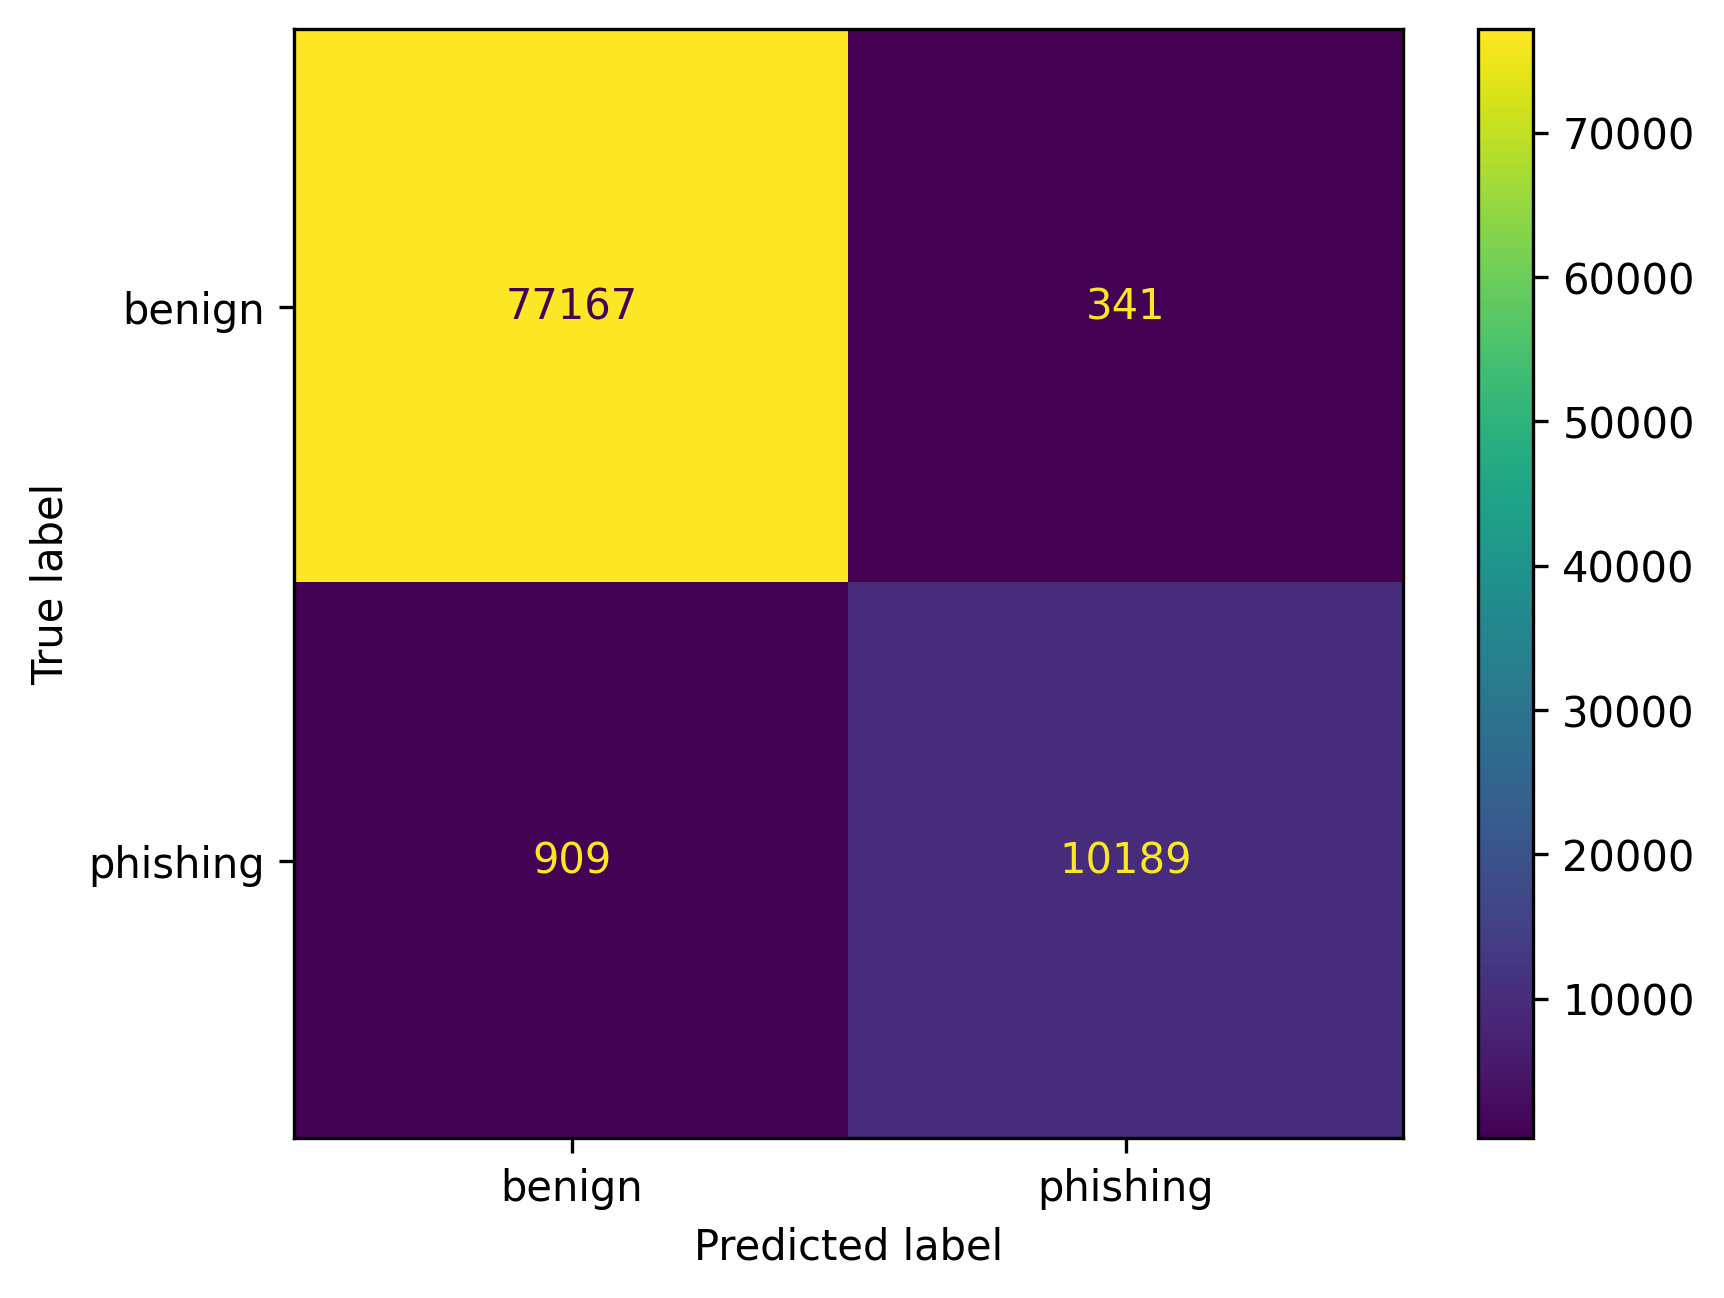

In [10]:
predicted = model.predict(X_test)

from sklearn.metrics import f1_score
print(f1_score(y_test, predicted))

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
print(classification_report(y_test, predicted, digits=4))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['benign', 'phishing'], values_format='d')

# Step 4: Explaining the model's predictions
(You can start from the cell where the pickled shap values are loaded if you already have them)

We can now use SHAP to gain insight into the model's predictions. First, shap values need to be computed for the test set. This is a computationally expensive process, but in practice, you can significantly reduce the time needed by using a narrower sample of the data, without affecting the results much. The following cell will compute shap values for the test set. It will also save the shap values to a file, so you can load them later without having to recompute them.

In [11]:
# initialize shap
import shap
# get shap values (use a smaller sample of the test set if you want to save coffee)
explainer = shap.TreeExplainer(model)
X_sample = X_test
shap_values = explainer.shap_values(X_sample)
# save the values for later use
import pickle
pickle.dump(shap_values, open("shap_values.pickle.dat", "wb"))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The shap values are now stored. You can later start all the way here (after running the mandatory cells in previous steps) to only play with SHAP.

In [12]:
# load the values to start from here
import pickle
shap_values = pickle.load(open("shap_values.pickle.dat", "rb"))

In [13]:
import shap
shap.initjs()
reverse_class_map = {v: k for k, v in class_map.items()}

## Force plot
The force plot shows the shap values for a single prediction. The values are sorted by their absolute value, so the most important features are the largest arrows. The color indicates the influence of the feature. The red color indicates a positive value, while the blue color indicates a negative value. The base value is the average prediction for the whole dataset. The output value is the prediction for the selected sample. The sum of the base value and the shap values is equal to the output value. You can see how each feature "forces" the shap value to its final resting position, determining the resulting prediction.

Note that the force plot is interactive, but that breaks with widgets. So instead just change the sample variable to see different samples and rerun the cell.

In [14]:
sample = 0

print("Predicted: %s" % reverse_class_map[model.predict(X_test.iloc[sample,:].values.reshape(1, -1))[0]])
print("Actual: %s" % reverse_class_map[y_test.iloc[sample]])
shap.force_plot(explainer.expected_value, shap_values[sample,:], X_test.iloc[sample,:])

Predicted: benign:unknown
Actual: benign:unknown


# Summary plot
The summary plot shows (in dot or violin mode) how individual feature values are distributed for each feature. The x-axis shows the shap value, while the color shows the feature value. The features are sorted by their importance, so the most important features are at the top. The color indicates the value of the feature. The red color indicates a high value, while the blue color indicates a low value. The zero line is the split point between outputs, just like the base value in the force plot. For some features, you might see that low values usually result in negative classification, while high values usually result in positive classification.

Another mode, bar, shows a mean shap value across all data points, which is effectively a plot of feature importance. Use the widgets to switch between modes and feature count. Also note that the violin and dot plots take a while to calculate, so you might want to start with a low feature count.

In [15]:
import ipywidgets as widgets
from ipywidgets import interact
plot_type = widgets.RadioButtons(
    options=['dot', 'layered_violin', 'bar'],
    value='layered_violin',
    description='Plot Type:',
    disabled=False
)
max_display = widgets.IntSlider(
    value=10,
    description='Max Display:',
    disabled=False,
    min=1,
    max=len(X_sample.columns)-1
)

@interact
def plot_shap(plot_type=plot_type, max_display=max_display):
        shap.summary_plot(shap_values, X_sample, plot_type=plot_type, class_names=class_map.values(), max_display=max_display, plot_size=[10, max_display])

interactive(children=(RadioButtons(description='Plot Type:', index=1, options=('dot', 'layered_violin', 'bar')…